In [1]:
from scipy import stats
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
EXP_BASE_DIR = "/home/darshan/work/course/dissertation/"

exp3A_1_path = EXP_BASE_DIR + "idiom_principle_on_magpie_corpus/experiments/exp3A_1/checkpoints/test_results_None.txt"
exp3B_1_path = EXP_BASE_DIR + "idiom_principle_on_magpie_corpus/experiments/exp3B_1/checkpoints_SeqClassifier/test_results_None.txt"
bt2_path = EXP_BASE_DIR + "bertram_on_magpie/experiments/bt2/checkpoints_SeqClassifier/test_results_None.txt"

# Select a pair of experiments
exp_1_file = exp3B_1_path
exp_2_file = bt2_path

exp_1_NAME = "exp3B_1"
exp_2_NAME = "bt2"

In [3]:
id_to_label = {0: 'i', 1: 'l'}
PROBABILITY_COL = "prediction_prob"

In [4]:
# Should contain tab separated 'index \t prediction \t prediction_prob' columns
exp_1_df = pd.read_csv(exp_1_file, sep='\t')
exp_2_df = pd.read_csv(exp_2_file, sep='\t')

In [5]:
SAMPLE_INDICES_FILEPATH = EXP_BASE_DIR + "idiom_principle_on_magpie_corpus/data/stat_significance/np_sample_indices.npy"

# # ONE-TIME ONLY: 
# # Sub-sampling using a fixed list of random indices
# PER_CLASS_SAMPLE_SIZE = 150
# testdf = pd.read_csv(EXP_BASE_DIR + "idiom_principle_on_magpie_corpus/experiments/exp3B_1/tmp/test.csv")
# ind_0 = testdf[testdf['label'] == 0].sample(n=PER_CLASS_SAMPLE_SIZE).index.tolist()
# ind_1 = testdf[testdf['label'] == 1].sample(n=PER_CLASS_SAMPLE_SIZE).index.tolist()
# np_sample_indices = np.append(ind_0, ind_1)

# np.save(SAMPLE_INDICES_FILEPATH, np_sample_indices)
# print(f"Saved the sample indices at {SAMPLE_INDICES_FILEPATH}")

In [6]:
# Load the list of sample indices to be used for statistical testing
np_sample_indices = np.load(SAMPLE_INDICES_FILEPATH)
print(f"Sample indices len: {len(np_sample_indices)}")

Sample indices len: 300


In [7]:
# Select only the required sample test instances
exp_1_df = exp_1_df.loc[np_sample_indices]
exp_2_df = exp_2_df.loc[np_sample_indices]
print(f"Selected the sample indices only")

Selected the sample indices only


In [8]:
# # Concatenate the two dataframes side-by-side
# all_cols = exp_1_df.columns
# exp1_renames = {col: f"{exp_1_NAME}_{col}" for col in all_cols}
# exp2_renames = {col: f"{exp_2_NAME}_{col}" for col in all_cols}
# exps_combined_df = pd.concat([exp_1_df.rename(columns=exp1_renames), exp_2_df.rename(columns=exp2_renames)], axis=1)
# exps_combined_df

Text(0.5, 1.0, 'Distribution of prediction probabilities')

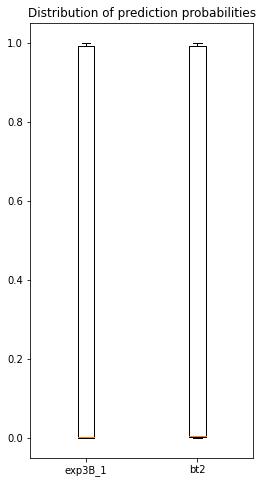

In [9]:
# Distributions of probabilities
fig, ax = plt.subplots(figsize=(4,8))
ax.boxplot([exp_1_df[PROBABILITY_COL], exp_2_df[PROBABILITY_COL]])
ax.set_xticklabels([exp_1_NAME, exp_2_NAME])
ax.set_title("Distribution of prediction probabilities")

In [10]:
exp_1_df[[PROBABILITY_COL]].describe()

,prediction_prob
count,300.000000
mean,0.308861
std,0.447205
min,0.000100
25%,0.000500
50%,0.002300
75%,0.991425
max,0.999700


In [11]:
exp_2_df[[PROBABILITY_COL]].describe()

,prediction_prob
count,300.000000
mean,0.313486
std,0.449483
min,0.000700
25%,0.001800
50%,0.004250
75%,0.991550
max,0.999200


In [12]:
# Check if the probabilities follow a normal distribution or not
# Use 'Shapiro-Wilk test' for normality test
W_test_value, p_value = stats.shapiro(exp_1_df[PROBABILITY_COL])
print(f"{exp_1_NAME} probabilities normality test: W={W_test_value}, p-value={p_value}")

W_test_value, p_value = stats.shapiro(exp_2_df[PROBABILITY_COL])
print(f"{exp_2_NAME} probabilities normality test: W={W_test_value}, p-value={p_value}")

exp3B_1 probabilities normality test: W=0.6167517900466919, p-value=2.471422083447875e-25
bt2 probabilities normality test: W=0.6159918308258057, p-value=2.354378051383135e-25


In [13]:
# Since both the p-values are significant (<0.5), both the distributions violate the assumption of normality. 
# Therefore, the Wilcoxon signed rank test, a.k.a the Wilcoxon T test, is the correct test to use to analyze this data.
# Ref https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/

In [14]:
# Statistical significance test
def statistical_significance_test(sequence_1, sequence_2):
    """
    Perform statistical significance test (wilcoxon-sign-ranked-test) on the two sequences.
    Print the results of the test.
    """
    # Ref https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/
    return stats.wilcoxon(sequence_1, sequence_2, zero_method='zsplit', correction=True)

In [15]:
statistical_significance_test(exp_1_df[PROBABILITY_COL], exp_2_df[PROBABILITY_COL])

WilcoxonResult(statistic=17471.5, pvalue=0.0006899449235501807)

## Interpretation of the results
The results are statistically significant! We can reject the null hypothesis in support of the alternative.

A **Wilcoxon T test** was used to analyze the prediction probabilities of *exp_1* and *exp_2* to test if the two models have predicted similarly or differently.

The p-value is lower the significance level of 0.01, hence we have statistically significant evidences to reject the null hypothesis(that the two data are similar) and to accept that the two data are different.
**Clearly, there is a statistically significant difference in the prediction probabilities between the two experiments. Hence, the observed differences in the model performance are not just by chance.**